<a href="https://colab.research.google.com/github/Sathiyan97/Finetunned-Faster-RCNN-for-wheat-spike-count/blob/main/wheat_spikes_using_faster_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/FYP-Data/Wheat Spikes'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/drive/MyDrive/FYP-Data/Wheat Spikes/train.csv
/content/drive/MyDrive/FYP-Data/Wheat Spikes/my_model-2.pth
/content/drive/MyDrive/FYP-Data/Wheat Spikes/train.gsheet
/content/drive/MyDrive/FYP-Data/Wheat Spikes/train/2171_1.jpg
/content/drive/MyDrive/FYP-Data/Wheat Spikes/train/2172_4.jpg
/content/drive/MyDrive/FYP-Data/Wheat Spikes/train/2181_4.jpg
/content/drive/MyDrive/FYP-Data/Wheat Spikes/train/2171_2.jpg
/content/drive/MyDrive/FYP-Data/Wheat Spikes/train/2172_3.jpg
/content/drive/MyDrive/FYP-Data/Wheat Spikes/train/2163_0.jpg
/content/drive/MyDrive/FYP-Data/Wheat Spikes/train/2171_4.jpg
/content/drive/MyDrive/FYP-Data/Wheat Spikes/train/2163_3.jpg
/content/drive/MyDrive/FYP-Data/Wheat Spikes/train/2181_3.jpg
/content/drive/MyDrive/FYP-Data/Wheat Spikes/train/2171_5.jpg
/content/drive/MyDrive/FYP-Data/Wheat Spikes/train/2152_3.jpg
/content/drive/MyDrive/FYP-Data/Wheat Spikes/train/2152_1.jpg
/content/drive/MyDrive/FYP-Data/Wheat Spikes/train/2152_4.jpg
/content/drive/MyDriv

# Faster RCNN

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
import random
from PIL import Image,ImageDraw
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load Data

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/FYP-Data/Wheat Spikes/train.csv')

In [ ]:
train.head()

image_id  width  height                 bbox      source
0   1011_0   1024    1024  [155, 500, 113, 68]  extend_set
1   1011_0   1024    1024  [218, 552, 125, 89]  extend_set
2   1011_0   1024    1024  [352, 547, 95, 110]  extend_set
3   1011_0   1024    1024   [543, 536, 48, 88]  extend_set
4   1011_0   1024    1024   [653, 535, 68, 64]  extend_set

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70939 entries, 0 to 70938
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  70939 non-null  object
 1   width     70939 non-null  int64 
 2   height    70939 non-null  int64 
 3   bbox      70939 non-null  object
 4   source    70939 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.7+ MB


# Data preprocessing

In [ ]:
coords=pd.DataFrame(list(train.bbox.apply(lambda x:x[1:-1].split(',')).values), columns=['x1','y1','w','h'])

In [ ]:
coords.head()

x1    y1     w     h
0  155   500   113    68
1  218   552   125    89
2  352   547    95   110
3  543   536    48    88
4  653   535    68    64

In [ ]:
df=pd.concat([train,coords],axis=1)
df.head()

image_id  width  height                 bbox      source   x1    y1     w  \
0   1011_0   1024    1024  [155, 500, 113, 68]  extend_set  155   500   113   
1   1011_0   1024    1024  [218, 552, 125, 89]  extend_set  218   552   125   
2   1011_0   1024    1024  [352, 547, 95, 110]  extend_set  352   547    95   
3   1011_0   1024    1024   [543, 536, 48, 88]  extend_set  543   536    48   
4   1011_0   1024    1024   [653, 535, 68, 64]  extend_set  653   535    68   

      h  
0    68  
1    89  
2   110  
3    88  
4    64

In [ ]:
df['x1']=pd.to_numeric(df['x1'])
df['y1']=pd.to_numeric(df['y1'])
df['w']=pd.to_numeric(df['w'])
df['h']=pd.to_numeric(df['h'])


In [ ]:
df['x2']=df['x1']+df['w']
df['y2']=df['y1']+df['h']


In [ ]:
df.drop(['bbox','width','height','w','h','source'],axis=1,inplace=True)

In [ ]:
df.head()

image_id   x1   y1   x2   y2
0   1011_0  155  500  268  568
1   1011_0  218  552  343  641
2   1011_0  352  547  447  657
3   1011_0  543  536  591  624
4   1011_0  653  535  721  599

In [ ]:
unique_imgs=df.image_id.unique()

In [ ]:
unique_imgs

array(['1011_0', '1011_1', '1011_2', ..., '6202_3', '6202_4', '6202_5'],
      dtype=object)

In [ ]:
class CustData(torch.utils.data.Dataset):
    def __init__(self,df,unique_imgs,indices):
        self.df=df
        self.unique_imgs=unique_imgs
        self.indices=indices
    def __len__(self):
        return len(self.indices)

    def __getitem__(self,idx):
        image_name=self.unique_imgs[self.indices[idx]]
        boxes=self.df[self.df.image_id==image_name].values[:,1:].astype('float')
        img=Image.open('/content/drive/MyDrive/FYP-Data/Wheat Spikes/train/'+image_name+'.jpg').convert('RGB')
        labels=torch.ones((boxes.shape[0]),dtype=torch.int64)
        target={}
        target['boxes']=torch.tensor(boxes)
        target['labels']=labels
        return T.ToTensor()(img),target



# Train test spliting

In [ ]:
train_inds,val_inds=train_test_split(range(unique_imgs.shape[0]),test_size=0.1)

In [ ]:
def custom_collate(data):
    return data

In [ ]:
train_dl=torch.utils.data.DataLoader( CustData(df,unique_imgs,train_inds),
                                     batch_size=15,
                                     shuffle=True,
                                     collate_fn=custom_collate,
                                     pin_memory=True if torch.cuda.is_available() else False

                                    )
val_dl=torch.utils.data.DataLoader( CustData(df,unique_imgs,val_inds),
                                     batch_size=8,
                                     shuffle=True,
                                     collate_fn=custom_collate,
                                     pin_memory=True if torch.cuda.is_available() else False

                                    )

In [ ]:
train_dl

# Model training

In [ ]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes =2 # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 246MB/s]


In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
optimizer=torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9,weight_decay=0.0005)
num_epochs=5

In [ ]:
model.to(device)
for epochs in range(num_epochs):
    epoch_loss=0
    for data in train_dl:
        imgs=[]
        targets=[]

        for d in data:
            imgs.append(d[0].to(device))
            targ={}
            targ['boxes']=d[1]['boxes'].to(device)
            targ['labels']=d[1]['labels'].to(device)
            targets.append(targ)

        loss_dict=model(imgs,targets)
        loss=sum(v for v in loss_dict.values())
        epoch_loss+=loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(epoch_loss)


# model evaluation

In [ ]:
# torch.save(model.state_dict(), '/kaggle/working/my_model.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/FYP-Data/Wheat Spikes/my_model-2.pth'))

<All keys matched successfully>

In [ ]:
model.eval()
data=iter(val_dl).__next__()

In [ ]:
# model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Print the status of parameter locking
for name, param in model.named_parameters():
    print("Parameter:", name, "Requires Gradient:", param.requires_grad)

# Print the status of batch normalization layers
for module in model.modules():
    if isinstance(module, torch.nn.BatchNorm2d) or isinstance(module, torch.nn.BatchNorm1d):
        print("Batch Normalization Layer:", module, "Training Mode:", module.training)

Parameter: backbone.body.conv1.weight Requires Gradient: False
Parameter: backbone.body.layer1.0.conv1.weight Requires Gradient: False
Parameter: backbone.body.layer1.0.conv2.weight Requires Gradient: False
Parameter: backbone.body.layer1.0.conv3.weight Requires Gradient: False
Parameter: backbone.body.layer1.0.downsample.0.weight Requires Gradient: False
Parameter: backbone.body.layer1.1.conv1.weight Requires Gradient: False
Parameter: backbone.body.layer1.1.conv2.weight Requires Gradient: False
Parameter: backbone.body.layer1.1.conv3.weight Requires Gradient: False
Parameter: backbone.body.layer1.2.conv1.weight Requires Gradient: False
Parameter: backbone.body.layer1.2.conv2.weight Requires Gradient: False
Parameter: backbone.body.layer1.2.conv3.weight Requires Gradient: False
Parameter: backbone.body.layer2.0.conv1.weight Requires Gradient: True
Parameter: backbone.body.layer2.0.conv2.weight Requires Gradient: True
Parameter: backbone.body.layer2.0.conv3.weight Requires Gradient: Tr

In [ ]:
img=data[0][0]
boxes=data[0][1]['boxes']
labels=data[0][1]['labels']

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
output=model([img.to(device)])

In [ ]:
output

[{'boxes': tensor([[7.6824e+02, 8.9232e+02, 8.8471e+02, 1.0224e+03],
          [6.6239e+01, 7.2395e+02, 1.7162e+02, 8.6897e+02],
          [3.2504e+02, 4.2610e+01, 4.0605e+02, 1.8548e+02],
          [6.7113e+02, 5.7228e+02, 8.1925e+02, 6.5524e+02],
          [3.3882e+02, 3.7553e+02, 4.0225e+02, 4.7646e+02],
          [3.9753e+02, 3.8088e+02, 4.6397e+02, 5.2382e+02],
          [3.8243e+01, 3.2273e+02, 1.6699e+02, 4.3020e+02],
          [4.5907e+02, 2.7905e+02, 5.2485e+02, 3.9890e+02],
          [7.0977e+02, 4.3553e+02, 8.3966e+02, 5.9551e+02],
          [3.5701e+02, 9.5429e+02, 4.1670e+02, 1.0240e+03],
          [1.6752e+01, 6.7556e+02, 1.0997e+02, 7.3142e+02],
          [9.5567e+01, 2.8906e+02, 2.2839e+02, 4.0067e+02],
          [4.5387e+02, 8.6095e+01, 5.8990e+02, 1.5541e+02],
          [4.7113e+02, 3.8688e+02, 5.5211e+02, 4.6906e+02],
          [9.3992e+02, 3.3328e+02, 1.0225e+03, 4.6828e+02],
          [7.1396e+02, 1.3602e+01, 8.0927e+02, 1.3542e+02],
          [1.5370e+02, 9.0627e+

In [ ]:
out_box=output[0]['boxes']
out_scores=output[0]['scores']

In [ ]:
keep=torchvision.ops.nms(out_box,out_scores,0.45)

In [ ]:
out_box.shape,keep.shape

(torch.Size([80, 4]), torch.Size([75]))

In [ ]:
im=(img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')

In [ ]:
im

array([[[109, 149,  63],
        [118, 154,  80],
        [110, 140,  66],
        ...,
        [ 22,  42,   0],
        [ 32,  53,   0],
        [ 35,  53,   1]],

       [[106, 146,  57],
        [117, 155,  72],
        [112, 144,  61],
        ...,
        [ 23,  44,   1],
        [ 27,  44,   2],
        [ 35,  50,  11]],

       [[101, 141,  52],
        [119, 155,  65],
        [117, 148,  55],
        ...,
        [ 17,  40,   0],
        [ 25,  41,   4],
        [ 41,  53,  15]],

       ...,

       [[ 13,  11,   0],
        [  4,   5,   0],
        [  9,  10,   2],
        ...,
        [150, 171,  66],
        [179, 193, 105],
        [173, 185, 109]],

       [[ 10,  12,   0],
        [  9,  11,   0],
        [  6,   8,   5],
        ...,
        [121, 146,  28],
        [162, 182,  71],
        [188, 205, 103]],

       [[ 10,  16,   0],
        [  8,  10,   5],
        [  4,   4,  12],
        ...,
        [ 93, 119,   0],
        [106, 129,   0],
        [195, 215,  92]]

# Model results

In [ ]:
vsample=Image.fromarray(im)

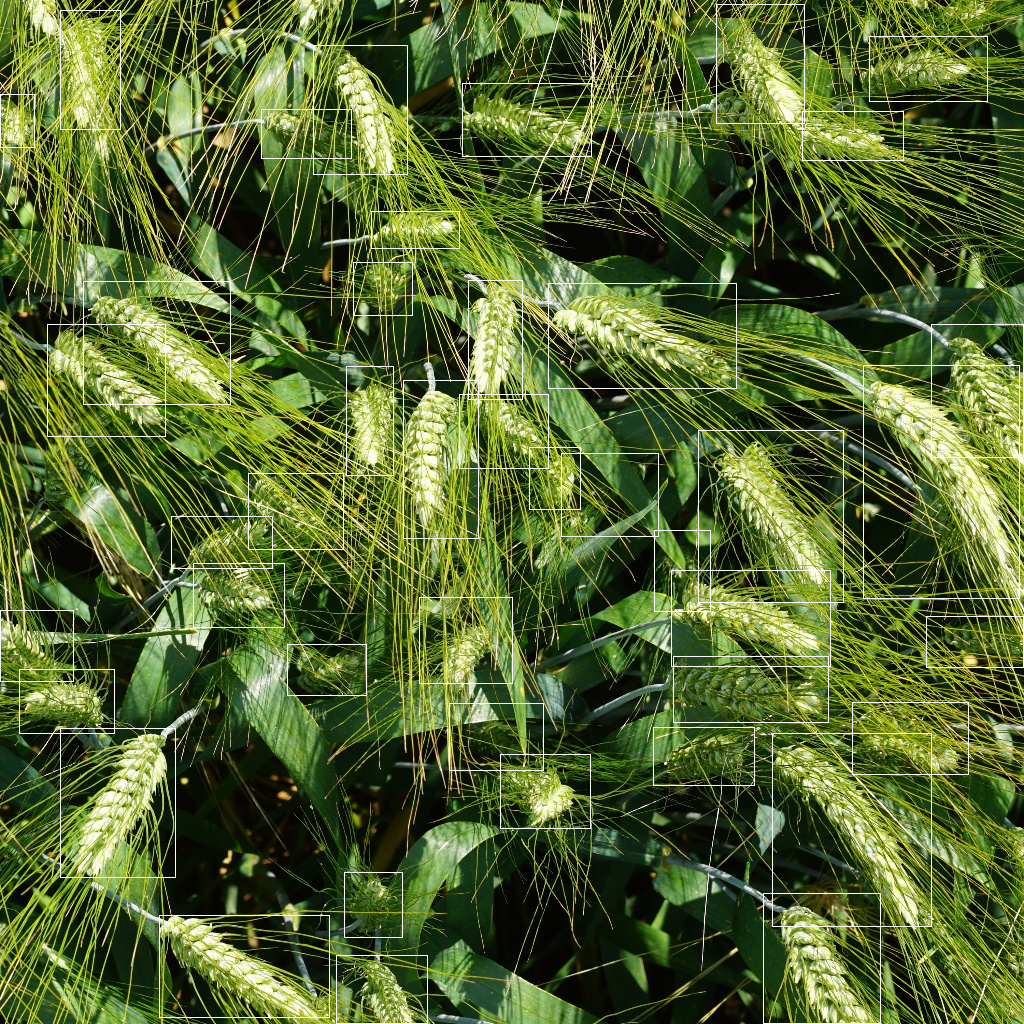

In [ ]:
draw=ImageDraw.Draw(vsample)
x = 0
for box in boxes:
    x +=1
    draw.rectangle(list(box),fill=None,outline='white')
vsample

In [ ]:
print(x)

43


# Testing custom image

In [ ]:
img1=Image.open('/content/drive/MyDrive/FYP-Data/Wheat Spikes/train/1101_1.jpg').convert('RGB')

In [ ]:
# Create a copy of the image to draw bounding boxes on
image_with_boxes = img1.copy()

In [ ]:
transform = T.Compose([T.ToTensor()])
input_image = transform(img1)

In [ ]:
type(input_image)

torch.Tensor

In [ ]:
output1=model([input_image.to(device)])

In [ ]:
out_box1=output1[0]['boxes']
out_scores1=output1[0]['scores']

In [ ]:
keep=torchvision.ops.nms(out_box1,out_scores1,0.60)

In [ ]:
out_box1.shape,keep.shape

(torch.Size([68, 4]), torch.Size([68]))

In [ ]:
im1=(input_image.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')

In [ ]:
vsample=Image.fromarray(im1)

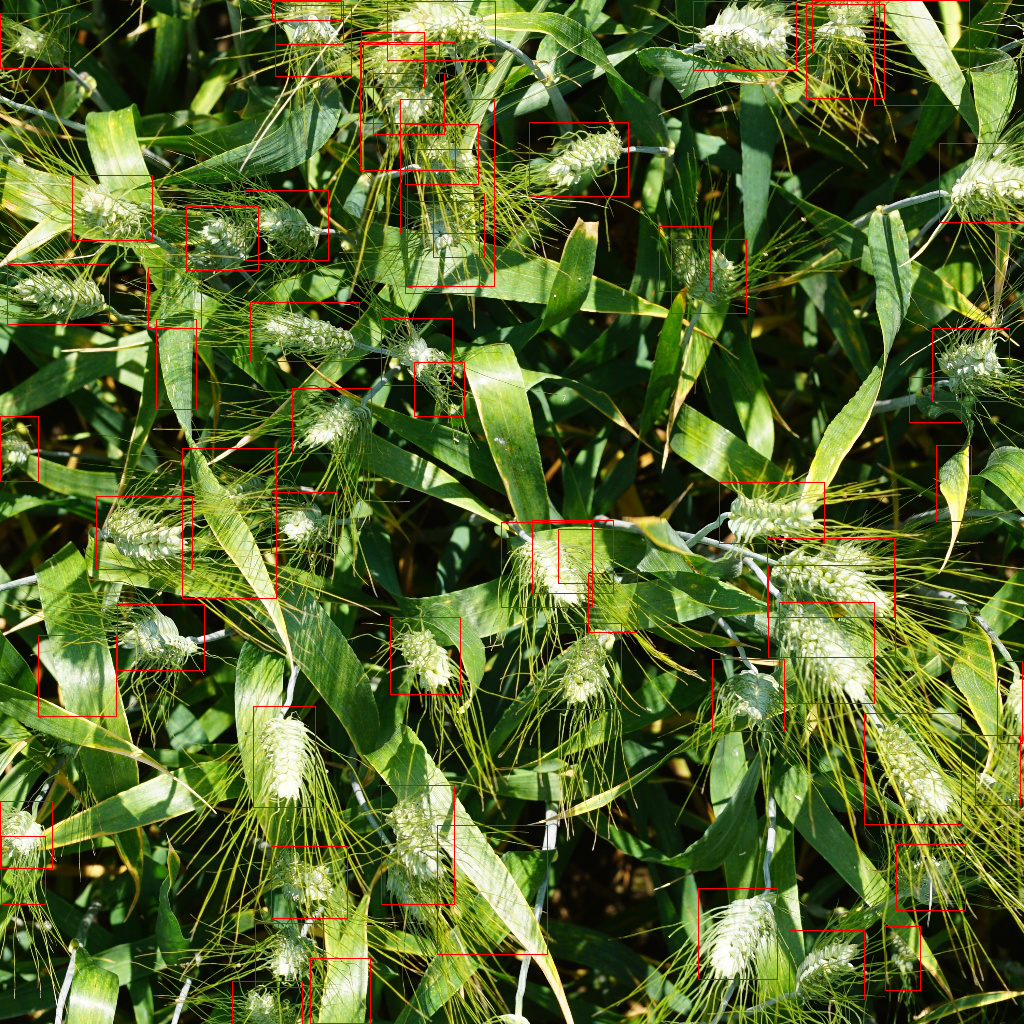

In [ ]:
draw=ImageDraw.Draw(vsample)
x = 0
for box in out_box1:
    x +=1
    draw.rectangle(list(box),fill=None,outline='red')
vsample

In [ ]:
print(x)

68


In [ ]:
import pandas as pd

# Assuming you have a DataFrame called 'df' with a column named 'column_name'
value_counts = train['image_id'].value_counts()

print(value_counts)

4011_5    96
4011_2    96
6122_4    95
1151_4    94
6122_3    94
          ..
4052_0    29
2182_0    28
2041_3    28
2181_0    28
1192_2    26
Name: image_id, Length: 1398, dtype: int64


In [ ]:
count = value_counts['1111_1']

print(count)
